quandl housing api:  
https://www.quandl.com/blog/api-for-housing-data

In [116]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import datetime
import random

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Quandl
import numpy as np

import utils as ut
from utils import RET_PER, FIG_WIDTH, FIG_HEIGHT

sns.set_context("paper")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
hoods = ut.load_hoods()
cities = ut.load_cities()
counties = ut.load_counties()
states = ut.load_states()
indicators = ut.load_indicators()

In [249]:
px_us = ut.load_quandl_data('regions','A').ix[:,0]
px_ca = ut.load_quandl_data('states','A').ix[:,0]
px_h = ut.load_quandl_data('hoods','A')

px_h = (px_h
        .fillna(method='bfill', limit=3)
        .fillna(method='ffill', limit=3)
        .dropna(axis=1))

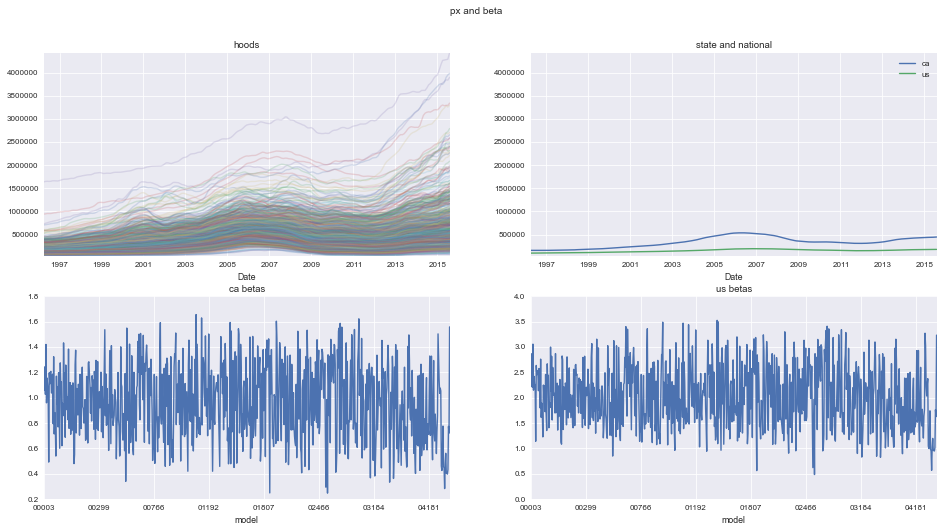

In [241]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(FIG_WIDTH*2, FIG_HEIGHT*2))
fig.suptitle('px and beta')

px_h.ix[:,:].plot(alpha=.2, legend=False, title='hoods', ax=axes[0,0])
df = pd.DataFrame({'us': px_us, 'ca': px_ca})
df.plot(title='state and national', ax=axes[0,1])

ymax = max(df.max().max(), px_h.max().max())
ymin = min(df.min().min(), px_h.min().min())
axes[0,0].set_ylim([ymin,ymax])
axes[0,1].set_ylim([ymin,ymax])

betas_ca = ut.get_betas(px_h, px_ca, per=RET_PER)
betas_ca.plot(title='ca betas', ax=axes[1,0])
betas_us = ut.get_betas(px_h, px_us, per=RET_PER)
betas_us.plot(title='us betas', ax=axes[1,1])

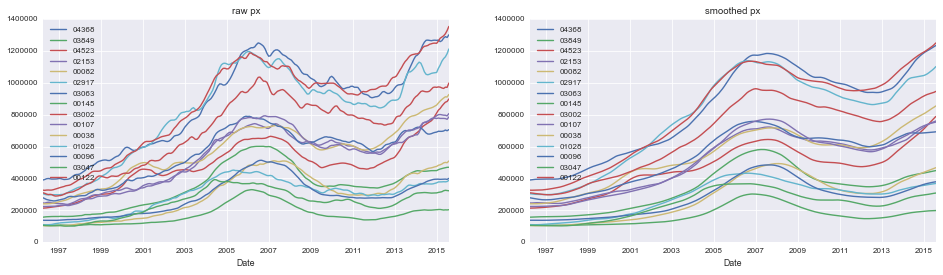

In [245]:
# fig, axes = plt.subplots(ncols=2, figsize=(FIG_WIDTH*2, FIG_HEIGHT))
# rand_cols = random.sample(px_h.columns, 15)
# px_h[rand_cols].plot(ax=axes[0], title='raw px')
# px_h = ut.kalman_ma(px_h)
# px_h[rand_cols].plot(ax=axes[1], title='smoothed px')

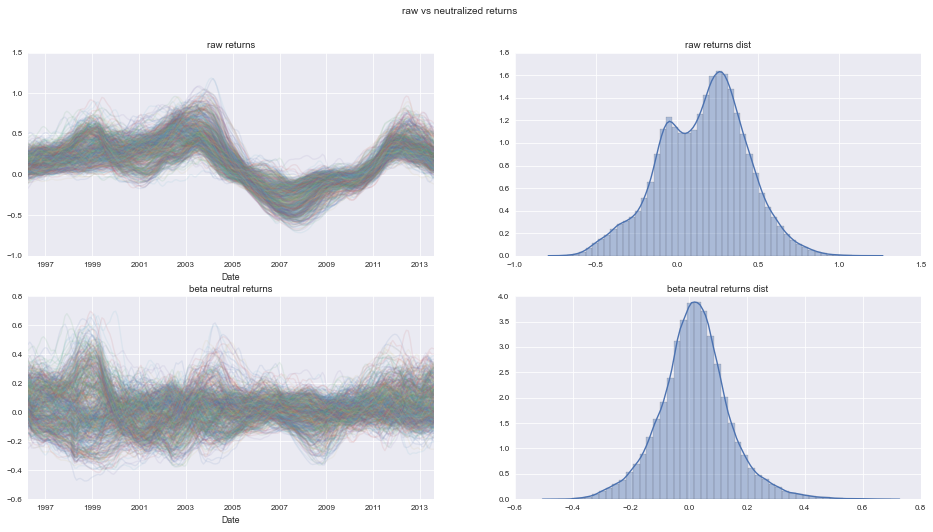

In [281]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(FIG_WIDTH*2, FIG_HEIGHT*2))
fig.suptitle('raw vs neutralized returns')

fwd_ret = ut.get_forward_return(px_h, periods=RET_PER)
fwd_ret.plot(legend=False, alpha=.1, ax=axes[0,0], title='raw returns')
sns.distplot(fwd_ret.stack(), ax=axes[0,1]).set_title('raw returns dist')

fwd_ret_nt = ut.get_beta_neutral_returns(px_h, px_ca, RET_PER, fwd=True)
fwd_ret_nt.plot(legend=False, alpha=.1, ax=axes[1,0], title='beta neutral returns')
sns.distplot(fwd_ret_nt.stack(), ax=axes[1,1]).set_title('beta neutral returns dist')

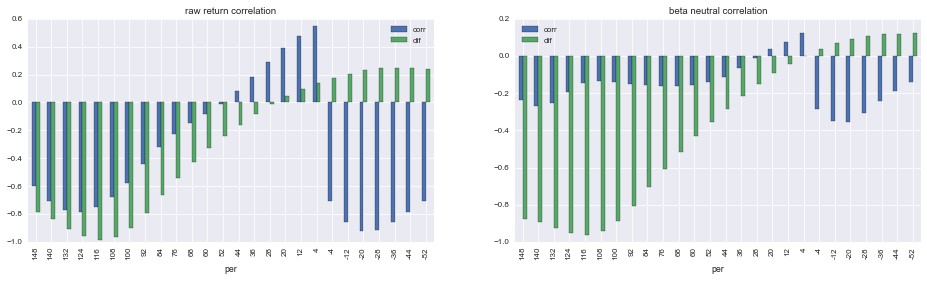

In [282]:
fig, axes = plt.subplots(ncols=2, figsize=(FIG_WIDTH*2, FIG_HEIGHT))
ut.lead_lag_corr(px_h, fwd_ret).plot(kind='bar', title='raw return correlation', ax=axes[0])
ut.lead_lag_corr(px_h, fwd_ret_nt).plot(kind='bar', title='beta neutral correlation', ax=axes[1])

In [224]:
MOM_PER = 24

{'f_test': None,
 'params': array([ 0.14232522]),
 'tvalues': array([ 255.84894447])}

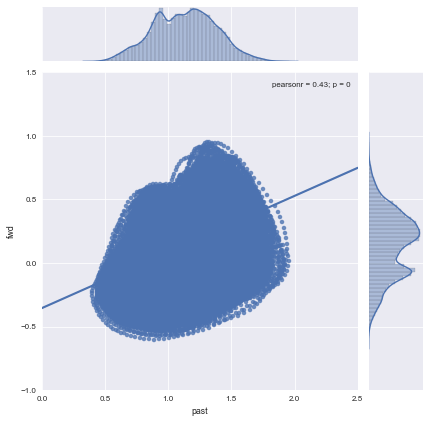

In [219]:
r = (px_h / px_h.shift(MOM_PER))
df = pd.concat([r.stack().to_frame(), fwd_ret.stack().to_frame()], axis=1).dropna()
df.columns = ['past', 'fwd']
sns.jointplot(df['past'], df['fwd'], kind="reg")
ut.simple_ols(df['past'].values, df['fwd'].values, fit_intercept=False)

{'f_test': None,
 'params': array([ 0.02014359]),
 'tvalues': array([ 60.28369618])}

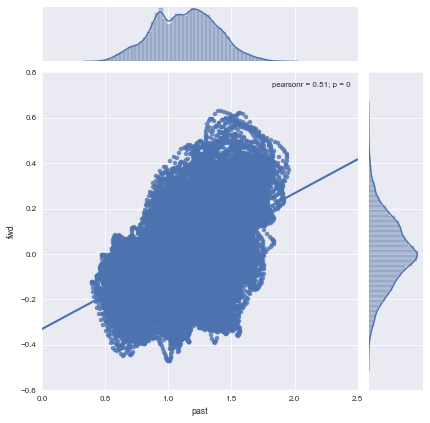

In [220]:
r = (px_h / px_h.shift(MOM_PER))
df = pd.concat([r.stack().to_frame(), fwd_ret_nt.stack().to_frame()], axis=1).dropna()
df.columns = ['past', 'fwd']
sns.jointplot(df['past'], df['fwd'], kind="reg")
ut.simple_ols(df['past'].values, df['fwd'].values, fit_intercept=False)

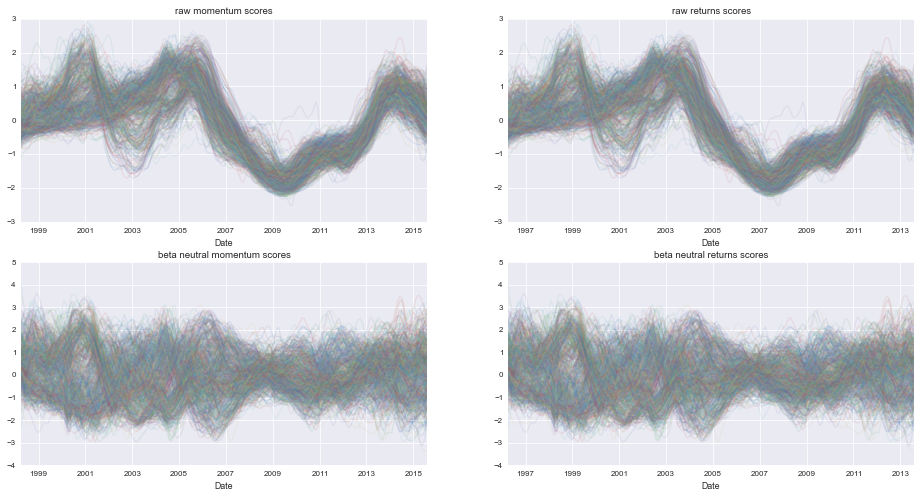

In [288]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(FIG_WIDTH*2, FIG_HEIGHT*2))

mom_sc = ut.ts_score((px_h / px_h.shift(MOM_PER)).dropna(how='all'))
mom_sc.plot(legend=False, alpha=.1, ax=axes[0,0], title='raw momentum scores')

fwd_ret_sc = ut.ts_score(fwd_ret)
fwd_ret_sc.plot(legend=False, alpha=.1, ax=axes[0,1], title='raw returns scores')

mom_nt = ut.get_beta_neutral_returns(px_h, px_ca, MOM_PER)
mom_nt_sc = ut.ts_score(mom_nt)
mom_nt_sc.plot(legend=False, alpha=.1, ax=axes[1,0], title='beta neutral momentum scores')

fwd_ret_nt_sc = ut.ts_score(fwd_ret_nt)
fwd_ret_nt_sc.plot(legend=False, alpha=.1, ax=axes[1,1], title='beta neutral returns scores')

In [290]:
fwd_ret_nt_sc.equals(mom_nt_sc)

False

In [16]:
df = ut.stack_and_align(mom, fwd_ret_ts, cols=['mom', 'fwd'])

In [17]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(df[['mom']], df['fwd'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [149]:
pred_score = pd.DataFrame(clf.predict(df[['mom']]), index=df.index, columns=['pred_score'])
pred_value = ut.z_score_to_value(df['mom'].unstack(), fwd_ret).stack()
pred_value.name = 'pred_value'
d = ut.stack_and_align([df['mom'], df['fwd'], pred_score, pred_value])
d['pred_err'] = df['fwd'] - pred_value
a = d[['fwd', 'pred_value']].applymap(lambda x: 1 if x > 0 else -1)
d['dir_accurate'] = a['fwd'] == a['pred_value']

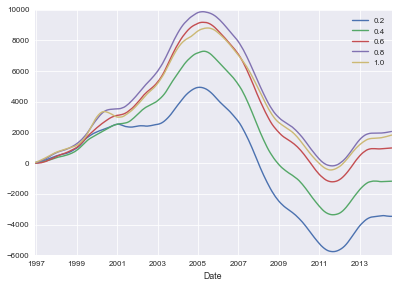

In [139]:
ut.gen_quintile_data(d, 'pred_score', 'fwd').cumsum().plot()

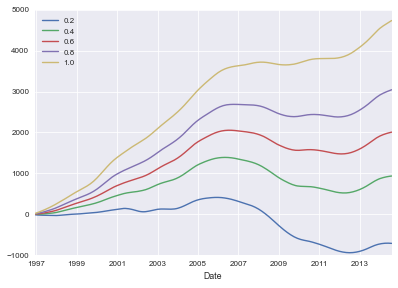

In [140]:
ut.gen_quintile_data(d, 'pred_score', 'pred_value').cumsum().plot()

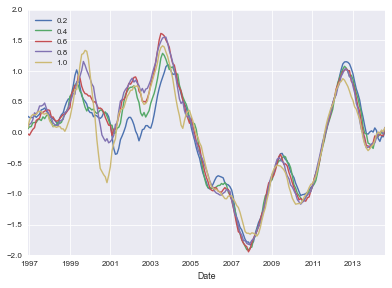

In [141]:
ut.gen_quintile_data(d, 'pred_score', 'pred_err', agg='mean').plot()

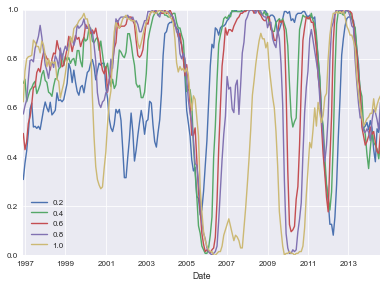

In [150]:
ut.gen_quintile_data(d, 'pred_score', 'dir_accurate', agg='mean').plot()

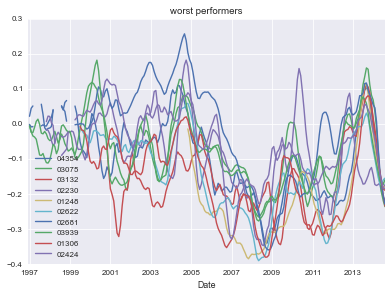

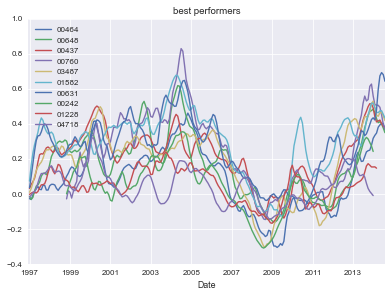

In [175]:
c = ut.get_cum_return(d['pred_value'].unstack(), outlier_threshold=10)
assets_ranked = c.tail(5).mean().order().index
c[assets_ranked[:10]].plot(title='worst performers')
c[assets_ranked[-10:]].plot(title='best performers')

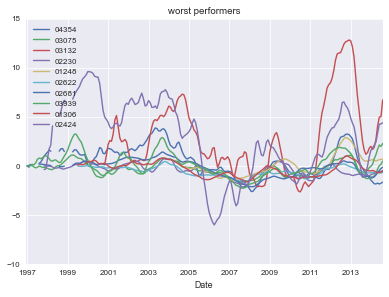

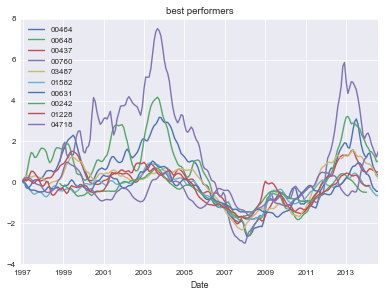

In [176]:
c = ut.get_cum_return(d['fwd'].unstack(), outlier_threshold=10)
c[assets_ranked[:10]].plot(title='worst performers')
c[assets_ranked[-10:]].plot(title='best performers')